# Optimizing selections

### Goals:

1. To understand a real situation in which we are optimizing selection criteria to distinguish between "signal" and "background", in a search for elusive dark matter particles.
2. To wonder what these dark matter particles are anyway.
3. To understand the different between "covariance" and "correlation" and the advantages and disadvantages of each.
4. To deepen out understanding with examples of quantities that are highly correlated and quantities that are uncorrelated.

### Timing

1. Try to finish this notebook in 25-30 minutes. 

### Question and Answer Template

You can go to the link below, and do "file" -> "make a copy" to make yourself a google doc that you can use to fill in the answers to the question in this weeks notebooks.

https://docs.google.com/document/d/1EbNCxetg0pD_-NjI_sj_aoIooPmLkd1fBBJCx1YhI9k/edit?usp=drive_link

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import scipy.interpolate as interp

plt.rcParams['font.size'] = 14

## Python functions reference

We will be using one simple new function to interpolate and subsequently evaluate an empirical/numerical relation. 

| Function Name            | What it does |
| - | - |
| scipy.interpolate.interp1d  | Given a set of data xvals and yvals, where yvals = f(xvals), compute y* = f(x*) for some x* within the range of xvals. See the [SciPy interpolation documentation](https://docs.scipy.org/doc/scipy/reference/interpolate.html) for more information |

# Hunting for dark matter in LUX-ZEPLIN

Only about 15% of the matter in the universe is composed of particles (electrons, protons, etc.) that scientists have been able to study in great detail. The other 85% is composed of an unknown, "dark" matter that can interact gravitationally, but whose other kinds of interactions aren't well understood.

There are a few different ways scientists can probe those other interactions of dark matter. Detectors like the LUX-ZEPLIN (LZ) detector shown below hope to "directly detect" dark matter by looking for rare scatters of dark matter particles on a target material. In LZ's case, a dark matter particle might interact with a atomic nucleus of one of the atoms within the detector (specifically, xenon). This produces flashes of light that can be detected, called "S1" and "S2." The presence of one or both of these tells us that we have seen a particle interacting with the xenon, which we refer to as an **"event"**.

<img src="figures/LZDetector.png" width="400"/>


However, just because we see an event, it doesn't mean we're necessarily seeing dark matter interact. For example, an S1+S2 may instead be created by a random interaction of an ambient $\gamma$ ray (high energy photon) or electron ($\beta$) hitting our xenon atoms. So to search for dark matter interactions, it is first important to understand the difference between those so-called "background" events, and so-called "signal" events:



**Background:** These are events from known physics, that may mimic dark matter. Examples: $\gamma$-ray interactions, $\beta$ interactions, etc. Think of these as "boring" events, which we don't care about seeing.

**Signal:** These are possible dark matter or other "new physics" events. These are "interesting" events.


In LZ, signal and background events have different detection signatures that allow us to distinguish whether an event is due to signal or background. For example, S2s of background events are slightly more bright than S2s of signal events, because $\gamma$'s and $\beta$'s tend to interact with the atomic electron cloud instead of the xenon nucleus, which effectively ionizes more electrons rather than producing scintillation light.

However, there are many different physics processes underlying the interactions that create the S1 and S2, and it's not possible to *perfectly* distinguish whether an individual event is signal or background. In other words, there's some fraction of background events that look more like signal events, and some fraction of signal events that look more like background events. This situation, where signal and backgrounds overlap to some degree, is extremely common in event-based experiments. In this lab, we will explore the analysis methods used to do searches for rare signals under such conditions.

# !! Note: careful with time usage

In this lab, we'll ask you some qualitative and quantitative questions about statistical methods for dark matter searches. Many of these can be answered in a single sentence or even a single number, so don't overthink them. Having enough time for the second lab this week is very important!

# Gathering Calibration Data
First, let's get a sense of what background data looks like. One way to do this is to calibrate the detector with some known $\beta$ source. Let's load in 100,000 events from a $\beta$ calibration source, and look at the sizes of the S2 flashes. There's a good deal of spread in these S2 sizes, so we typically look at the logarithm of the S2 size instead of the size itself, i.e. Log10(S2).

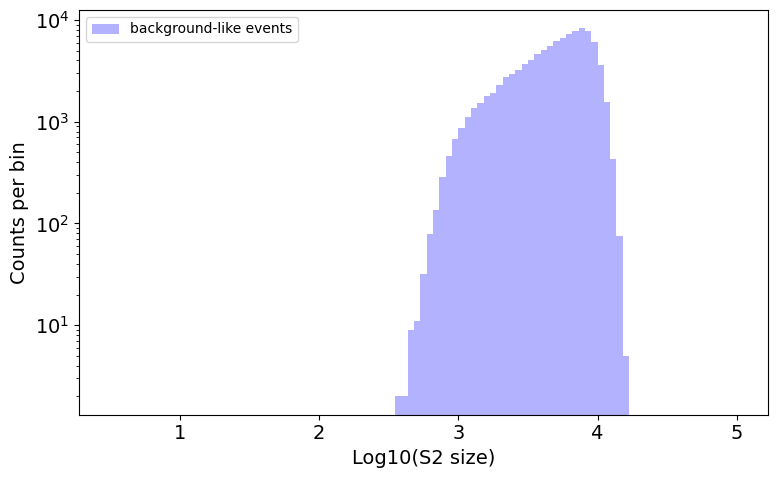

In [2]:
## Load the calibration data, consisting of "background-like" events. 
## Note that each line of the data file represents one event
backgroundlike_calibration_data = np.loadtxt(open("../data/background_calibration_data.txt",'r'))

## Take the log of the S2 values so we can see a larger range.
backgroundlike_logS2 = np.log10(backgroundlike_calibration_data[:])

## Make some bins for plotting, where we'll note the bins are for the
## log10(S2) values, which span about 5 orders of magnitude.
backgroundlike_logS2Bins = np.linspace(0.5, 5, 100)

## Plot these events
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(backgroundlike_logS2, bins=backgroundlike_logS2Bins, 
        fc=(0, 0, 1, 0.3), label="background-like events")

ax.set_xlabel(r'Log10(S2 size)')
ax.set_ylabel(r'Counts per bin')
ax.set_yscale('log')

ax.legend(fontsize=10)

fig.tight_layout() 
plt.show()

Now, let's try to get a sense of what signal-like data will look like. As mentioned above, we expect dark matter scatters to look a bit different than $\gamma$ or $\beta$ scatters. Since humans haven't yet detected dark matter, we can't calibrate <i>with</i> real dark matter scatters. However, neutrons interact in a similar way to dark matter (they interact with the nucleus of the atom rather than the electron cloud), so we can shoot some neutrons into our detector to get a "signal-like" calibration dataset. Let's load in 100,000 of those.

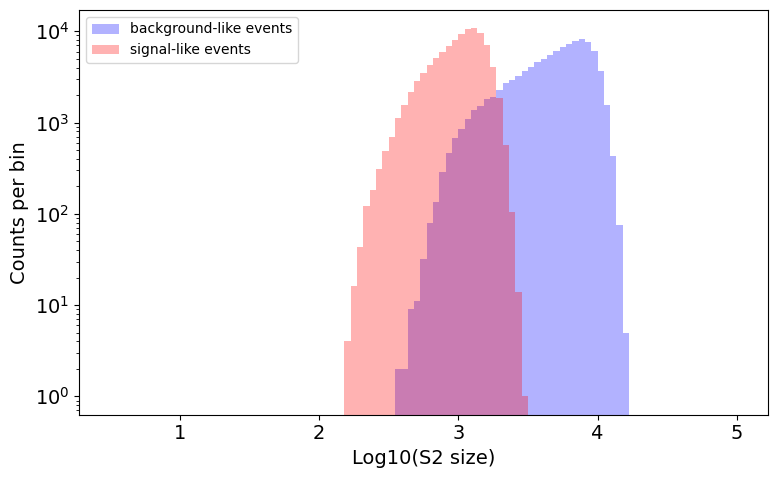

In [3]:
## Load in the neutron (signal-like) calibration events
signallike_calibration_data = np.loadtxt(open("../data/neutron_calibration_data.txt",'r'))

## Take the log of the S2 values again to see a larger range
signallike_logS2 = np.log10(signallike_calibration_data[:])

## Plot these on the same axes as the background-like calibration data
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(backgroundlike_logS2, bins=backgroundlike_logS2Bins,
         fc=(0, 0, 1, 0.3), label="background-like events")
ax.hist(signallike_logS2, bins=backgroundlike_logS2Bins,
         fc=(1, 0, 0, 0.3), label="signal-like events")

ax.set_xlabel(r'Log10(S2 size)')
ax.set_ylabel(r'Counts per bin')
ax.set_yscale('log')

ax.legend(fontsize=10)

fig.tight_layout() 
plt.show()

### Questions for Discussion
#### 1.1 What are we plotting in the above two plots? What does an individual entry in the blue histogram represent? What does an individual entry in the red histogram represent?

#### 1.2 The peaks of the two histograms are separated in Log10(S2) space. What does this separation mean for our ability to distinguish background-like ($\beta$) events from signal-like (neutron) events?

#### 1.3 What do the widths of the two histograms mean? What does it mean that the histograms overlap a little bit? 

# Defining a background cut

Now we want to use these calibration datasets to come up with a selection criteria, or "cut", to remove events that we know are extremely likely to be background-like. For simplicity, let's just cut away all events with Log(S2) above a certain value $X_{c}$. An example is below.

In [4]:
## Function we use to help us cut away events with S2s above a 
## certain threshold cutVal
def cut_events(eventList, cutVal):
    
    ## Make a mask of all events passing the cut
    mask = eventList < cutVal

    ## Apply that mask to the event list by indexing with the
    ## boolean array
    return eventList[mask]

<b>Note:</b> to change the cut value, you can modify the variable `cutValue_Xc` below. (You'll need to do this anyway for the next few questions!)

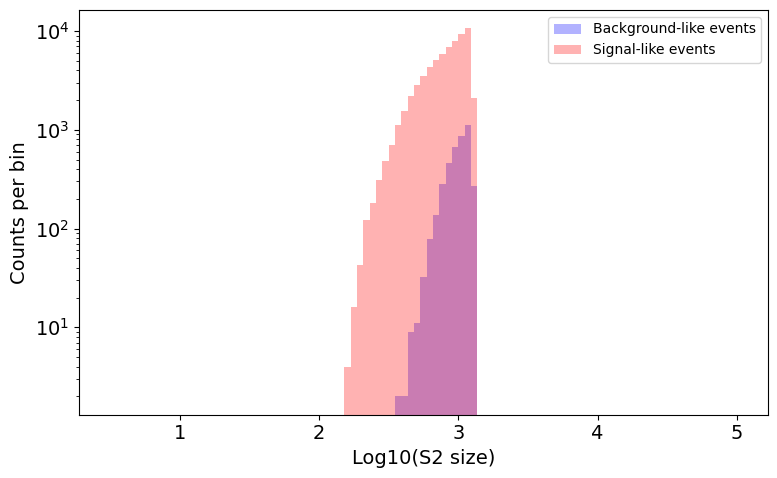

Number of signal-like events remaining after cut: 65579
Number of background-like events remaining after cut: 3925


In [5]:
## Define a cut value - play with this! Look at both the distribution
## and the number of events remaining after the cut.
cutValue_Xc = 3.1


## Cut both the signal and background events
signallike_logS2_afterCut = cut_events(signallike_logS2, cutValue_Xc)
backgroundlike_logS2_afterCut = cut_events(backgroundlike_logS2, cutValue_Xc)

## Plot the results after the cut
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(backgroundlike_logS2_afterCut, bins=backgroundlike_logS2Bins,
         fc=(0, 0, 1, 0.3), label="Background-like events")
ax.hist(signallike_logS2_afterCut, bins=backgroundlike_logS2Bins,
         fc=(1, 0, 0, 0.3), label="Signal-like events")

ax.set_xlabel(r'Log10(S2 size)')
ax.set_ylabel(r'Counts per bin')
ax.set_yscale('log')

ax.legend(fontsize=10)

fig.tight_layout() 
plt.show()

## Print the number of events remaining after the cut
print(f"Number of signal-like events remaining after cut: {signallike_logS2_afterCut.size}")
print(f"Number of background-like events remaining after cut: {backgroundlike_logS2_afterCut.size}")

### Questions for discussion

#### 2.1 Play around with the cut value, $X_c$, to get a sense of what events remain if you change $X_c$. Include in your write-up two screenshots of this plot, each corresponding to a different cut value. Include with both plots the number of signal-like and background-like events remaining for that cut value.

#### 2.2 In the end, we will want a cut that removes background events but keeps signal (dark matter) events. If we are expecting our dark matter events to follow a distribution with the same shape as the red histogram, where do you think we might want to set our cut value?

# Acceptance, Leakage, and Optimizing our Cut

The real "art" to performing a dark matter (or rare event) search is in figuring out the best place to put a background cut. To quantify this a bit, we have to define two quantities:

<b>Signal-like event acceptance:</b> This is the fraction of signal-like events that remain once we cut away events above $X_{c}$. 

<b>Background-like event leakage:</b> This is the fraction of background-like events that remain once we cut away events above $X_{c}$.

The goal, then, is to try to minimize the background leakage while keeping the signal acceptance high. Let's illustrate this with some calculations.

### Questions

#### 3.1 In the code above, set $X_{c}=2.0$. How many true signal events do we accept with our cut? How many background events leak into our selection? What is the disadvantage of such a strict cut?

#### 3.2 In the code above, now set $X_{c}=4.5$. How many true signal events do we accept? How many background events leak into our selection? What is the disadvantage of such a relaxed cut? (Side note: due to a slight bug in my code this neutron dataset actually has 97,713 events, not 100,000 as originally claimed.)

In principle, we'll want a cut somewhere in between $X_{c}=2.0$ and $X_{c}=4.5$, and we'll want to choose that cut based on the signal acceptance and background leakage. We compute those below.

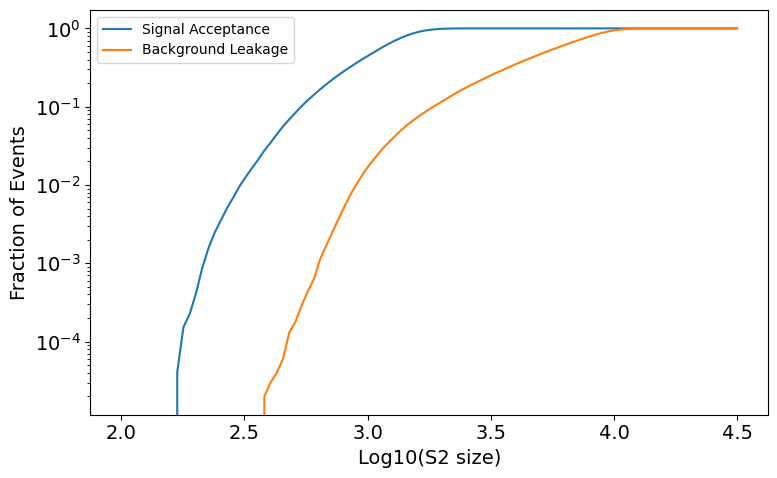

In [6]:
## Create a range of different cut values so explore the concepts
## of signal acceptance and background leakage.
nPoints = 100
cutVal_list = np.linspace(2.0, 4.5, nPoints)

## Instantiate some arrays to hold the signal acceptance and
## background leakage for each cut value
signalAcceptance = np.zeros(nPoints)
backgroundLeakage = np.zeros(nPoints)

## For each cut value in the list, determine the number of 
## signal and background events that pass the cut, and store
## them in the respective arrays.
for ind, cv in enumerate(cutVal_list):
    signalAcceptance[ind] = cut_events(signallike_logS2,cv).size
    backgroundLeakage[ind] = cut_events(backgroundlike_logS2,cv).size

## Normalize by the total number of events to express the 
## acceptance and leakage as fractions.
signalAcceptance /= signallike_logS2.size
backgroundLeakage /= backgroundlike_logS2.size

## Plot the signal acceptance and background leakage as 
## functions of the cut value
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(cutVal_list, signalAcceptance, label=r"Signal Acceptance")
ax.plot(cutVal_list, backgroundLeakage, label=r"Background Leakage")

ax.set_xlabel(r'Log10(S2 size)')
ax.set_ylabel(r'Fraction of Events')
ax.set_yscale('log')

ax.legend(fontsize=10)

fig.tight_layout() 
plt.show()

You could also *interpolate* the `signalAcceptance` and `backgroundLeakage` data arrays that we just created in order to evaluate these quantities numerically given any specific cut value, rather than just doing our best to read it off a plot for some choice of cut value.

There are many different ways to interpolate data, the most trivial method being accomplished by just "connecting the dots", i.e. building up a piecewise function comprised of linear segments between each data point. If we have data points $(x_i, \, y_i)$, then the linear interpolating function that describes their relation over the domain $\{x_i\}$ is given by,
$$
f_{\rm interp}(x) = 
    \begin{dcases}
        \dots, & \dots \\
        \left(\frac{y_{i+1} - y_i}{x_{i+1} - x_i}\right) (x - x_i) + y_i, & x_{i+1} > x \geq x_i \\
        \dots, & \dots \\
    \end{dcases}
$$

In [7]:
## Make an interpolating function for each curve based on the data.
## There are many optional arguments to the interp1d function, but the 
## defaults are fine for now.
signalAcceptanceInterp = interp.interp1d(cutVal_list, signalAcceptance)
backgroundLeakageInterp = interp.interp1d(cutVal_list, backgroundLeakage)

Then we can evaluate the `signalAcceptance` and `backgroundLeakage` for a particular cut value! As an example, we'll use the default cut $X_c = 3.1$ that was defined above (although you should definitely plug in your own cut value when evaluating these expressions)

In [8]:
## Default value for the cut. Change this number!
cutValue_Xc = 3.1

print(f'Signal Acceptance at Xc = {cutValue_Xc:0.1f}  : {signalAcceptanceInterp(cutValue_Xc):0.3g}')
print(f'Background Leakage at Xc = {cutValue_Xc:0.1f} : {backgroundLeakageInterp(cutValue_Xc):0.3g}')

Signal Acceptance at Xc = 3.1  : 0.671
Background Leakage at Xc = 3.1 : 0.039


### Questions for discussion

#### 4.1 Suppose we set our cut at $X_{c}=3.5$. Based on these curves, what is the fraction of background events that will survive the cut? What is the fraction of signal events that will survive the cut?

Signal acceptance and background leakage curves are good tools to understand how to select cuts, because they describe how cuts affect the signal and background populations, independent of the normalizations those populations (i.e. how many signal/background events we have in total). However, these normalizations are important to consider in order to optimize our cut value.

#### 4.2 If my dark matter signal has the same distribution shape as the neutron calibration data, but we're only expecting 10 dark matter events total, on average how many dark matter events should survive a cut at $X_{c}=3.5$?

#### 4.3 If my background has the same distribution shape as the background calibration data, but we're expecting 200 background events total, on average how many background events should survive a cut at $X_{c}=3.5$?

#### 4.4 Assume a Poisson uncertainty on the number of surviving background events (i.e. the standard deviation is the square root of the number of surviving events). Given the number you found in 4.3, will a cut at $X_{c}=3.5$ allow us to confidently say that we've discovered dark matter in this scenario? Why or why not? Is there a way to better improve the sensitivity of our search?

#### 4.5 Using the answers to the last few questions, I want you to propose a cut value for $X_{c}$ that you think is best for confidently identifying whether we see dark matter events. Keep in mind that dark matter interactions are rare enough that none have been conclusively detected yet.